#### Not part of the exercises

### Experiment with the DBSCAN properties

* Read up on the epsilon and min_samples arguments into DBSCAN at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
* Experiment with altering the epsilon values (the eps argument holding the threshhold parameter). Run the models and visualize the results. What has changed? Why do you think that is?
* Double the min_samples parameter. Run your model and visualize the results. Consider what changed and why.

In [46]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline
from env import host, username, password

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

## Clustering - DBSCAN

1. Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.
2. Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.
3. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

***

### Steps

1. Select variables you want to cluster: ```df = df[["col1", "col2"]]```
2. Convert to array & dtype float: ```np_array = df.values.astype("float32", copy = False)```
3. Scale to standard normal:
    ``` scaler = StandardScaler().fit(np_array) np_array = scaler.transform(np_array)```

4. Create DBSCAN object and fit: 
    ```dbsc = DBSCAN(eps = .75, min_samples = 15).fit(np_array)```
    
5. Extract labels: ```labels = dbsc.labels_```

6. Add labels back to original dataframe:
```df['labels'] = labels```

7. Explore:
```df.labels.value_counts() sns.scatterplot(df.col1, df.col2, hue=df.labels)```

***
1. While using Codeup's grocery_db in their MySQL server, use DBSCAN to detect anomalies in products from the customers dataset.

In [9]:
def get_db_url(database, host=host, user=username, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [55]:
# Select variables I want to cluster
# df = df[["col1", "col2"]] or more columns.
frozen_goods = df[['Grocery', 'Frozen']]
frozen_goods.head(3)

mishmash = df[['Fresh', 'Frozen', 'Grocery', 'Delicassen']]

In [57]:
# Normalize each attribute by scaling it to 0 mean and unit variance. 
# This helps to keep the inter-relationships between the features intact 
# so that a small change in one feature would reflect in the other.

# Make the scaler
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()

# Fit the scaler
scaler.fit(frozen_goods)
scaler2.fit(mishmash)

# Use the scaler
frozen_goods = scaler.transform(frozen_goods)
mishmash = scaler2.transform(mishmash)
#frozen_goods
# It is a very long array, so unhash if you wish to see the results.


In [58]:
# Construct a DBSCAN object that requires a minimum of 20 data points in a neighborhood of radius 0.1 to be considered a core point.

# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(frozen_goods)
dbsc.fit(mishmash)

DBSCAN(eps=0.1, min_samples=20)

In [61]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Grocery", "Frozen"]
scaled_columns = ["Scaled_" + column for column in columns]

columns2 = ['Fresh', 'Frozen', 'Grocery', 'Delicassen']
scaled_columns2 = ["Scaled_" + column for column in columns2]

# Save a copy of the original dataframe
original_df = df.copy()
original_df2 = original_df.copy()
df2 = original_df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(frozen_goods, columns=scaled_columns)
scaled_df2 = pd.DataFrame(mishmash, columns=scaled_columns2)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

df2 = df2.merge(scaled_df2, on=df2.index)
df2 = df2.drop(columns=['key_0'])

In [63]:
# Next, extract our cluster labels and outliers to plot our results

# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()

df2['labels'] = dbsc.labels_
df2.labels.value_counts()


 0    410
-1     30
Name: labels, dtype: int64

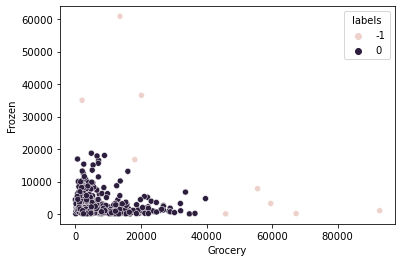

In [54]:
sns.scatterplot(df.Grocery, df.Frozen, hue=df.labels)
plt.show()

In [65]:
columns2

['Fresh', 'Frozen', 'Grocery', 'Delicassen']

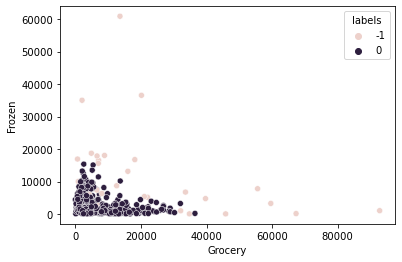

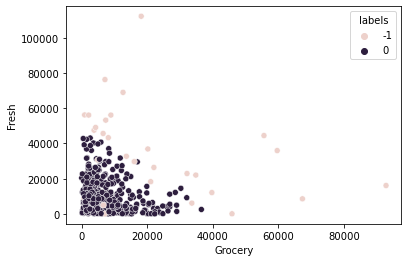

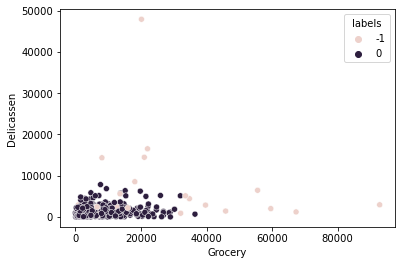

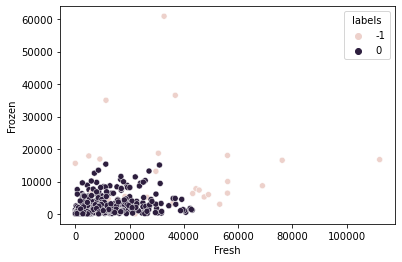

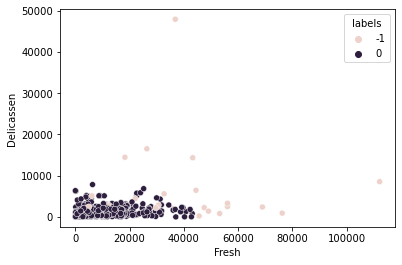

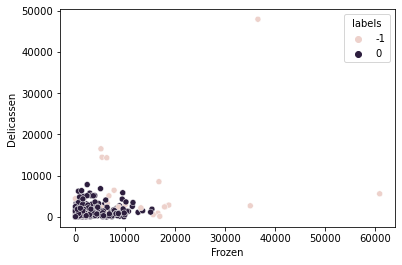

In [66]:
sns.scatterplot(df2.Grocery, df2.Frozen, hue=df2.labels)
plt.show()

sns.scatterplot(df2.Grocery, df2.Fresh, hue=df2.labels)
plt.show()

sns.scatterplot(df2.Grocery, df2.Delicassen, hue=df2.labels)
plt.show()

sns.scatterplot(df2.Fresh, df2.Frozen, hue=df2.labels)
plt.show()

sns.scatterplot(df2.Fresh, df2.Delicassen, hue=df2.labels)
plt.show()

sns.scatterplot(df2.Frozen, df2.Delicassen, hue=df2.labels)
plt.show()

Text(0.5, 0, 'Grocery')

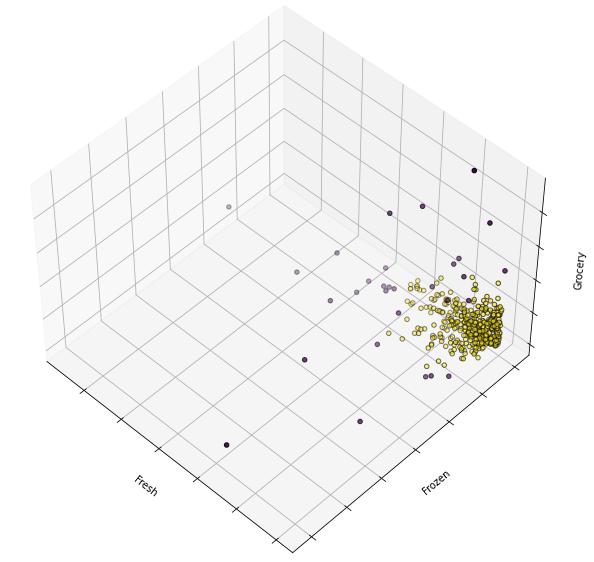

In [67]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Frozen, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Frozen')
ax.set_zlabel('Grocery')


Text(0.5, 0, 'Delicassen')

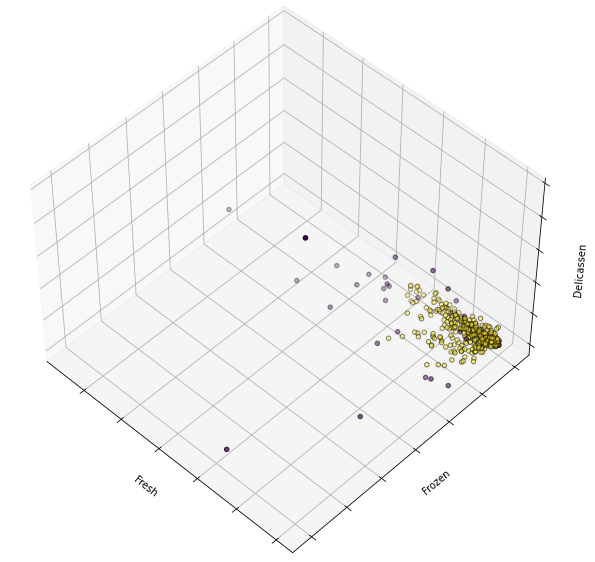

In [68]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Frozen, df.Delicassen,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Frozen')
ax.set_zlabel('Delicassen')

***
***
2. Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [35]:
url = get_db_url("curriculum_logs")

sql = """
select *
from logs
"""

df2 = pd.read_sql(sql, url)
df2.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [36]:
# This takes a little while to generate, so I'll save to csv
df2.to_csv('logs.csv')

In [37]:
# and use read csv from now on
df2 = pd.read_csv('logs.csv')

In [41]:
# even after playing around with kwargs in both to_csv and read_csv, a weird column remained
# bye bye weird column
df2 = df2.drop(columns='Unnamed: 0')

In [42]:
df2

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


***
***
3. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror)

In [5]:
df3 = pd.read_csv('filteredzillow.csv', index_col='parcelid')

In [ ]:
pd.read_csv()

In [ ]:
df3